<a href="https://colab.research.google.com/github/pratimdas/googlecolab/blob/main/Chapter_2_Recipe_15_Summary_Statistics_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recipe 15: Summary Statistics Function
Using /content/sample_data/retail_store_sales.csv

**Purpose**:
Create a single, reusable function to generate a bird’s-eye summary of each column—showing data types, missingness, cardinality, top categories, and basic numeric stats—using method chaining.


In [ ]:
# Step 1: Import libraries and load the dataset
import pandas as pd
from IPython.display import display

# Load the CSV (or fall back to df_clean if available)
filepath = '/content/sample_data/retail_store_sales.csv'
try:
    df = pd.read_csv(filepath, low_memory=False)
    print(f"✅ Loaded raw DataFrame: shape = {df.shape}")
except FileNotFoundError:
    # If you’ve already cleaned, use df_clean
    df = globals().get('df_clean')
    if df is None:
        raise FileNotFoundError(f"File not found and no df_clean in scope: {filepath}")
    print(f"⚠️  Using existing df_clean: shape = {df.shape}")


✅ Loaded raw DataFrame: shape = (12575, 11)


In [ ]:
# Step 2: Define the summary function using method chaining
def summarize_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a summary DataFrame with:
      - dtype:      original dtype of each column
      - n_missing:  count of NaNs
      - pct_missing: percent of NaNs
      - n_unique:   number of unique values
      - top_value:  most frequent value (incl. NaN)
      - top_freq:   frequency of that value
      - mean, median, min, max: for numeric columns only
    """
    # Base summary
    base = (
        pd.DataFrame({
            'dtype':      df.dtypes,
            'n_missing':  df.isna().sum(),
            'pct_missing': (df.isna().mean() * 100).round(2),
            'n_unique':   df.nunique(dropna=False)
        })
    )

    # Top value and its count
    top_data = []
    for col in df.columns:
        top_counts = df[col].value_counts(dropna=False)
        top_value = top_counts.idxmax() if not top_counts.empty else None
        top_freq = top_counts.iloc[0] if not top_counts.empty else 0
        top_data.append({'column': col, 'top_value': top_value, 'top_freq': top_freq})

    top = pd.DataFrame(top_data).set_index('column')


    # Numeric stats
    num_stats = (
        df
        .select_dtypes(include='number')
        .agg(['mean', 'median', 'min', 'max'])
        .T
    )

    # Combine all pieces
    summary = (
        base
        .join(top[['top_value', 'top_freq']], how='left')
        .join(num_stats,        how='left')
    )
    return summary

# Step 3: Run and display the summary
summary_df = summarize_df(df)
display(summary_df)

,dtype,n_missing,pct_missing,n_unique,top_value,top_freq,mean,median,min,max
Transaction ID,object,0,0.00,12575,TXN_2407494,1,NaN,NaN,NaN,NaN
Customer ID,object,0,0.00,25,CUST_05,544,NaN,NaN,NaN,NaN
Category,object,0,0.00,8,Electric household essentials,1591,NaN,NaN,NaN,NaN
Item,object,1213,9.65,201,NaN,1213,NaN,NaN,NaN,NaN
Price Per Unit,float64,609,4.84,26,33.5,678,23.365912,23.0,5.0,41.0
Quantity,float64,604,4.80,11,10.0,1232,5.536380,6.0,1.0,10.0
Total Spent,float64,604,4.80,228,NaN,604,129.652577,108.5,5.0,410.0
Payment Method,object,0,0.00,3,Cash,4310,NaN,NaN,NaN,NaN
Location,object,0,0.00,2,Online,6354,NaN,NaN,NaN,NaN
Transaction Date,object,0,0.00,1114,2022-05-30,26,NaN,NaN,NaN,NaN


# Recipe 16: Detecting Mixed Data Types
Using /content/sample_data/retail_store_sales.csv

**Purpose**:
Identify columns where values don’t conform to their inferred pandas dtype—e.g., numeric fields containing stray strings—so you can target and correct mixed-type anomalies before modeling.


In [ ]:
# Step 1: Import libraries and load the dataset
import pandas as pd
from IPython.display import display

filepath = '/content/sample_data/retail_store_sales.csv'
try:
    df = pd.read_csv(filepath, low_memory=False)
    print(f"✅ Loaded DataFrame: shape = {df.shape}")
except FileNotFoundError:
    df = globals().get('df_clean')
    if df is None:
        raise FileNotFoundError(f"File not found and no df_clean in scope: {filepath}")
    print(f"⚠️  Using existing df_clean: shape = {df.shape}")


✅ Loaded DataFrame: shape = (12575, 11)


In [ ]:
# Step 2: Define a function to detect mixed-type issues
def detect_mixed_types(df: pd.DataFrame, sample_size: int = None) -> pd.DataFrame:
    """
    Returns a summary DataFrame identifying:
      - dtype: inferred pandas dtype
      - n_non_numeric: count of non-numeric entries in object columns
      - pct_non_numeric: percentage of those entries
    """
    data = df.copy()
    if sample_size:
        data = data.sample(sample_size, random_state=42)

    results = []
    total = len(data)
    for col in data.columns:
        dtype = data[col].dtype
        non_numeric = None
        pct_non_numeric = None

        if dtype == 'object':
            # Attempt numeric conversion
            coerced = pd.to_numeric(data[col], errors='coerce')
            mask = data[col].notna() & coerced.isna()
            non_numeric = int(mask.sum())
            pct_non_numeric = round(non_numeric / total * 100, 2)
        else:
            non_numeric = 0
            pct_non_numeric = 0.0

        results.append({
            'column': col,
            'dtype': str(dtype),
            'n_non_numeric': non_numeric,
            'pct_non_numeric': pct_non_numeric
        })

    summary = pd.DataFrame(results).set_index('column')
    return summary


In [ ]:
# Step 3: Run detection and display results
mixed_summary = detect_mixed_types(df)
print("\n🔍 Mixed-Type Detection Summary")
display(mixed_summary)



🔍 Mixed-Type Detection Summary


,dtype,n_non_numeric,pct_non_numeric
column,,,
Transaction ID,object,12575,100.00
Customer ID,object,12575,100.00
Category,object,12575,100.00
Item,object,11362,90.35
Price Per Unit,float64,0,0.00
Quantity,float64,0,0.00
Total Spent,float64,0,0.00
Payment Method,object,12575,100.00
Location,object,12575,100.00


In [ ]:
# Step 4 (Optional): Inspect offending values for each problematic column
for col, row in mixed_summary.iterrows():
    if row['n_non_numeric'] > 0:
        print(f"\n❗ Column '{col}' has {row['n_non_numeric']} non-numeric entries "
              f"({row['pct_non_numeric']}%). Sample values:")
        display(df[col][df[col].notna() & pd.to_numeric(df[col], errors='coerce').isna()]
                .unique()[:10])



❗ Column 'Transaction ID' has 12575 non-numeric entries (100.0%). Sample values:


array(['TXN_6867343', 'TXN_3731986', 'TXN_9303719', 'TXN_9458126',
       'TXN_4575373', 'TXN_7482416', 'TXN_3652209', 'TXN_1372952',
       'TXN_9728486', 'TXN_2722661'], dtype=object)


❗ Column 'Customer ID' has 12575 non-numeric entries (100.0%). Sample values:


array(['CUST_09', 'CUST_22', 'CUST_02', 'CUST_06', 'CUST_05', 'CUST_07',
       'CUST_21', 'CUST_23', 'CUST_25', 'CUST_14'], dtype=object)


❗ Column 'Category' has 12575 non-numeric entries (100.0%). Sample values:


array(['Patisserie', 'Milk Products', 'Butchers', 'Beverages', 'Food',
       'Furniture', 'Electric household essentials',
       'Computers and electric accessories'], dtype=object)


❗ Column 'Item' has 11362 non-numeric entries (90.35%). Sample values:


array(['Item_10_PAT', 'Item_17_MILK', 'Item_12_BUT', 'Item_16_BEV',
       'Item_6_FOOD', 'Item_1_FOOD', 'Item_16_FUR', 'Item_22_BUT',
       'Item_3_BUT', 'Item_2_FOOD'], dtype=object)


❗ Column 'Payment Method' has 12575 non-numeric entries (100.0%). Sample values:


array(['Digital Wallet', 'Credit Card', 'Cash'], dtype=object)


❗ Column 'Location' has 12575 non-numeric entries (100.0%). Sample values:


array(['Online', 'In-store'], dtype=object)


❗ Column 'Transaction Date' has 12575 non-numeric entries (100.0%). Sample values:


array(['2024-04-08', '2023-07-23', '2022-10-05', '2022-05-07',
       '2022-10-02', '2023-11-30', '2023-06-10', '2024-04-02',
       '2023-04-26', '2024-03-14'], dtype=object)

# Recipe 17: Google Cloud Storage Loading & Diagnostics
**Purpose**:
Load your retail sales CSV directly from Google Cloud Storage into Colab and run the same diagnostics (null counts, duplicate checks, heatmap) you’ve learned—demonstrating seamless cloud integration.

In [ ]:
# Install required packages
!pip install --upgrade pandas gcsfs

from google.colab import auth
import os

# Trigger Colab's authentication flow
auth.authenticate_user()

# Ensure GOOGLE_APPLICATION_CREDENTIALS env var points to your service account JSON
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/your-service-account.json"

In [ ]:
# Step 2: getting the file from Google Cloud GCS bucket
import pandas as pd

# GCS path to your file
gcs_path = "gs://python-genai-dataengg-book/sample_data/retail_store_sales.csv"

# Read directly via pandas (gcsfs handles the protocol)
df_gcs = pd.read_csv(gcs_path, storage_options={"token": "cloud"})
print(f"✅ Loaded DataFrame from GCS: shape = {df_gcs.shape}")


✅ Loaded DataFrame from GCS: shape = (12575, 11)


In [ ]:
# Step 3: Inspect nulls and duplicates
# Null counts
null_counts = df_gcs.isna().sum()
print("Missing values per column:\n", null_counts)

# Duplicate counts (full-row and key-based)
full_dups = df_gcs.duplicated().sum()
key_dups  = df_gcs.duplicated(subset=['Customer ID','Transaction Date','Item']).sum()
print(f"\nFull-row duplicates: {full_dups}")
print(f"Key-based duplicates ([Customer ID, Transaction Date, Item]): {key_dups}")


Missing values per column:
 Transaction ID         0
Customer ID            0
Category               0
Item                1213
Price Per Unit       609
Quantity             604
Total Spent          604
Payment Method         0
Location               0
Transaction Date       0
Discount Applied    4199
dtype: int64

Full-row duplicates: 0
Key-based duplicates ([Customer ID, Transaction Date, Item]): 40


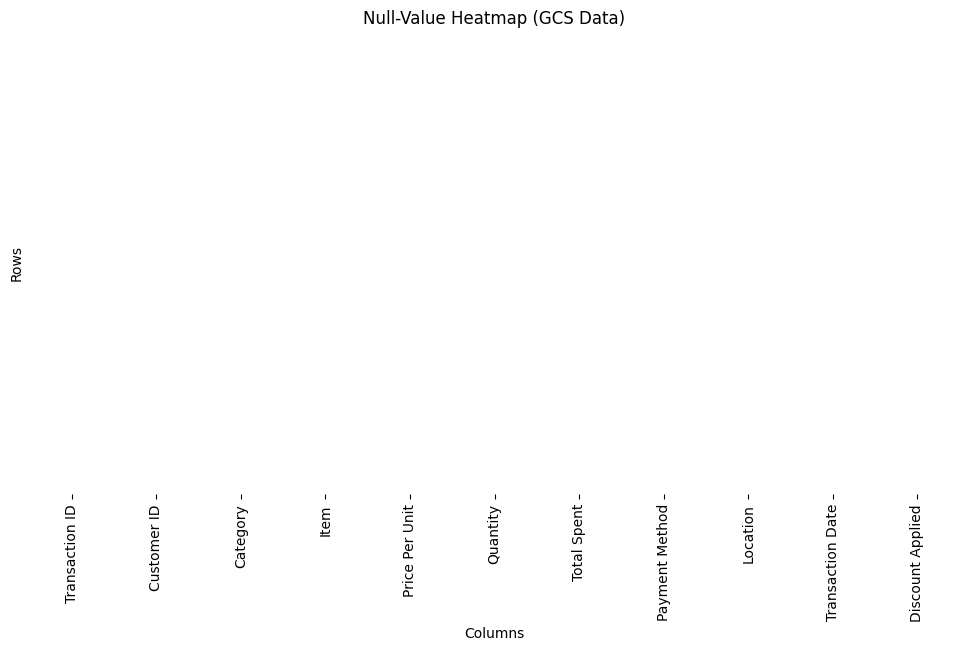

In [ ]:
# Step 4: Plot null-heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(
    df_gcs.isna(),
    cbar=False,
    yticklabels=False,
    cmap='viridis',
    linewidths=0.5
)
plt.title('Null-Value Heatmap (GCS Data)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()


In [ ]:
# Define the plot_null_heatmap function (reused from a previous recipe concept)
import seaborn as sns
import matplotlib.pyplot as plt

def plot_null_heatmap(df: pd.DataFrame):
    """
    Plots a heatmap showing the distribution of null values in a DataFrame.
    """
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        df.isna(),
        cbar=False,
        yticklabels=False,
        cmap='viridis',
        linewidths=0.5
    )
    plt.title('Null-Value Heatmap')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()

# Recipe 17 - AWS version


In [ ]:
# Install required packages
!pip install --upgrade pandas s3fs

# Step 1: Import libraries and configure AWS credentials
import os
import pandas as pd

# (If you haven’t already) set your AWS creds via Colab secrets:
# os.environ['AWS_ACCESS_KEY_ID']     = "<YOUR_ACCESS_KEY_ID>"
# os.environ['AWS_SECRET_ACCESS_KEY'] = "<YOUR_SECRET_ACCESS_KEY>"
# os.environ['AWS_SESSION_TOKEN']     = "<YOUR_SESSION_TOKEN>"  # if needed

print("AWS Access Key:", os.getenv("AWS_ACCESS_KEY_ID"))

# Step 2: Read the CSV from S3
s3_path = "s3://my-bucket/retail_store_sales.csv"

# pandas + s3fs will handle the S3 protocol
df_s3 = pd.read_csv(s3_path, storage_options={"anon": False})
print(f"✅ Loaded DataFrame from S3: shape = {df_s3.shape}")

# Step 3: Inspect missing values and duplicates
# Null counts
null_counts = df_s3.isna().sum()
print("Missing values per column:\n", null_counts)

# Duplicate counts (full-row and key-based)
full_dups = df_s3.duplicated().sum()
key_dups  = df_s3.duplicated(subset=['Customer ID','Transaction Date','Item']).sum()
print(f"\nFull-row duplicates: {full_dups}")
print(f"Key-based duplicates ([Customer ID, Transaction Date, Item]): {key_dups}")

# Step 4: Plot null-heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(
    df_s3.isna(),
    cbar=False,
    yticklabels=False,
    cmap='viridis',
    linewidths=0.5
)
plt.title('Null-Value Heatmap (S3 Data)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

# Step 5 (Optional): Wrap in a helper function
def load_and_diagnose_s3(path: str):
    df = pd.read_csv(path, storage_options={"anon": False})
    print("Shape:", df.shape)
    print("\nNulls:\n", df.isna().sum())
    print("\nFull-row duplicates:", df.duplicated().sum())
    print("Key-based duplicates:", df.duplicated(subset=['Customer ID','Transaction Date','Item']).sum())
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap='viridis', linewidths=0.5)
    plt.title('Null-Value Heatmap (S3 Data)')
    plt.show()
    return df

# Usage
# df_s3 = load_and_diagnose_s3(s3_path)




AWS Access Key: None


# Recipe 17 - Azure Version


In [ ]:
# Install required packages
!pip install --upgrade pandas azure-storage-blob seaborn matplotlib

# Step 1: Import libraries and configure credentials
import os
from io import BytesIO

from azure.storage.blob import BlobServiceClient
import pandas as pd

# Ensure your connection string is available
conn_str = os.getenv("AZURE_STORAGE_CONNECTION_STRING")
if not conn_str:
    raise RuntimeError("Please set AZURE_STORAGE_CONNECTION_STRING in your Colab secrets")



In [ ]:
# Step 2: Download the blob into memory
# Initialize the BlobServiceClient
service_client = BlobServiceClient.from_connection_string(conn_str)

# Reference your container and blob
container_name = "mycontainer"
blob_name      = "retail_store_sales.csv"

blob_client = service_client.get_blob_client(container=container_name, blob=blob_name)

# Download the blob’s content as bytes
stream = blob_client.download_blob().readall()
print(f"✅ Downloaded {len(stream)} bytes from Azure Blob Storage")

# Step 3: Load into a pandas DataFrame
# Wrap the bytes in a BytesIO and read with pandas
df_az = pd.read_csv(BytesIO(stream), low_memory=False)
print(f"✅ Loaded DataFrame from Azure Blob: shape = {df_az.shape}")

# Step 4: Inspect missing values and duplicates
# Missing values
null_counts = df_az.isna().sum()
print("Missing values per column:\n", null_counts)

# Duplicate counts
full_dups = df_az.duplicated().sum()
key_dups  = df_az.duplicated(subset=['Customer ID','Transaction Date','Item']).sum()
print(f"\nFull-row duplicates: {full_dups}")
print(f"Key-based duplicates ([Customer ID, Transaction Date, Item]): {key_dups}")




In [ ]:
# Step 5: Plot null-heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(
    df_az.isna(),
    cbar=False,
    yticklabels=False,
    cmap='viridis',
    linewidths=0.5
)
plt.title('Null-Value Heatmap (Azure Blob Data)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

# Step 6 (Optional): Helper function
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(
    df_az.isna(),
    cbar=False,
    yticklabels=False,
    cmap='viridis',
    linewidths=0.5
)
plt.title('Null-Value Heatmap (Azure Blob Data)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()
